In [1]:
import xarray as xr
import torch
import torch.nn as nn
from torch import tensor
from torch.utils.data import random_split, Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
#from torch.optim.lr_scheduler import ReduceLROnPlateau
from typing import Tuple
import numpy as np
import zarr
import pandas as pd
import cftime
import yaml
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error


def r2_score_multi(y_pred: np.ndarray, y_true: np.ndarray) -> float:
    """Calculated the r-squared score between 2 arrays of values

    :param y_pred: predicted array
    :param y_true: "truth" array
    :return: r-squared metric
    """
    return r2_score(y_pred.flatten(), y_true.flatten())


with open(f"config.yaml") as stream:
    try:
        CONFIG = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

# Set rollout length
ROLLOUT = 4  # 4  # 12  # 1  # 4
torch.cuda.empty_cache()

In [2]:
CONFIG

{'clim_feats': ['clim_clake',
  'clim_ldepth',
  'clim_ctype',
  'clim_landsea',
  'clim_glm',
  'clim_cu',
  'clim_cvh',
  'clim_cvl',
  'clim_geopot',
  'clim_sdfor',
  'clim_sdor',
  'clim_theta_cap',
  'clim_theta_pwp',
  'clim_veg_covh',
  'clim_veg_covl',
  'clim_veg_z0mh',
  'clim_veg_z0ml',
  'clim_veg_rsminh',
  'clim_veg_rsminl'],
 'dynamic_feats': ['met_lwdown',
  'met_psurf',
  'met_qair',
  'met_rainf',
  'met_swdown',
  'met_snowf',
  'met_tair',
  'met_wind_e',
  'met_wind_n',
  'lai_hv',
  'lai_lv'],
 'targets_prog': ['swvl1',
  'swvl2',
  'swvl3',
  'stl1',
  'stl2',
  'stl3',
  'snowc_recalc',
  'sd',
  'rsn',
  'tsn'],
 'targets_diag': ['d2m', 't2m', 'skt'],
 'file_path': '/ec/scratch/daep/ecland_i6aj_chunked.zarr',
 'start_year': 2015,
 'end_year': 2020,
 'validation_start': 2021,
 'validation_end': 2021,
 'x_slice_indices': [0, 'None'],
 'roll_out': 8,
 'batch_size': 1000,
 'num_workers': 16,
 'hidden_dim': 192,
 'max_epochs': 250,
 'strategy': 'ddp',
 'devices': 1

In [3]:
# Set device
if torch.cuda.is_available(): 
    dev = "cuda:0" 
else: 
    dev = "cpu" 
device = torch.device(dev) 
device

device(type='cuda', index=0)

In [4]:
# Inspect dataset and variables
# da = xr.open_zarr("/hpcperm/daep/ec_land_training_db/ecland_i6aj_o400_2010_2022_6h_euro.zarr")
#da = xr.open_zarr("/hpcperm/daep/ec_land_training_db/ecland_i6aj_o400_2010_2022_6h.zarr")
da = xr.open_zarr("/hpcperm/daep/ecland_i6aj_2017_2022_6h_euro.zarr")
da

<xarray.Dataset> Size: 15GB
Dimensions:                     (x: 12536, clim_variable: 23, time: 8640,
                                 variable: 34)
Coordinates:
  * clim_variable               (clim_variable) object 184B 'clim_cell_area' ...
    lat                         (x) float32 50kB dask.array<chunksize=(12536,), meta=np.ndarray>
    lon                         (x) float32 50kB dask.array<chunksize=(12536,), meta=np.ndarray>
  * time                        (time) datetime64[ns] 69kB 2017-01-01 ... 202...
  * variable                    (variable) object 272B 'met_ctpf' ... 'log10_sd'
  * x                           (x) int32 50kB 15653 16004 ... 147383 147384
Data variables: (12/18)
    clim_data                   (x, clim_variable) float32 1MB dask.array<chunksize=(12536, 23), meta=np.ndarray>
    clim_maxs                   (clim_variable) float32 92B dask.array<chunksize=(23,), meta=np.ndarray>
    clim_means                  (clim_variable) float32 92B dask.array<chunksize=(23,), meta=np.ndarray>
    clim_mins                   (clim_variable) float32 92B dask.array<chunksize=(23,), meta=np.ndarray>
    clim_stdevs                 (clim_variable) float32 92B dask.array<chunksize=(23,), meta=np.ndarray>
    data                        (time, x, variable) float32 15GB dask.array<chunksize=(4, 12536, 34), meta=np.ndarray>
    ...                          ...
    global_data_1stdiff_means   (x, variable) float32 2MB dask.array<chunksize=(12536, 34), meta=np.ndarray>
    global_data_1stdiff_stdevs  (x, variable) float32 2MB dask.array<chunksize=(12536, 34), meta=np.ndarray>
    global_data_maxs            (x, variable) float32 2MB dask.array<chunksize=(12536, 34), meta=np.ndarray>
    global_data_means           (x, variable) float32 2MB dask.array<chunksize=(12536, 34), meta=np.ndarray>
    global_data_mins            (x, variable) float32 2MB dask.array<chunksize=(12536, 34), meta=np.ndarray>
    global_data_stdevs          (x, variable) float32 2MB dask.array<chunksize=(12536, 34), meta=np.ndarray>

In [5]:
class EcDataset(Dataset):
    # load the dataset
    def __init__(
        self,
        start_yr=2015,
        end_yr=2020,
        x_idxs=(0, "None"),
        path="/hpcperm/daep/ec_land_training_db/ecland_i6aj_o400_2010_2022_6h_euro.zarr",
        roll_out=ROLLOUT,
    ):
        self.ds_ecland = zarr.open(path)
        # Create time index to select appropriate data range
        date_times = pd.to_datetime(
            cftime.num2pydate(
                self.ds_ecland["time"], self.ds_ecland["time"].attrs["units"]
            )
        )
        self.start_index = min(np.argwhere(date_times.year == int(start_yr)))[0]
        self.end_index = max(np.argwhere(date_times.year == int(end_yr)))[0]
        self.times = np.array(date_times[self.start_index : self.end_index])
        self.len_dataset = self.end_index - self.start_index

        # Select points in space
        self.x_idxs = (0, None) if "None" in x_idxs else x_idxs
        self.x_size = len(self.ds_ecland["x"][slice(*self.x_idxs)])
        self.lats = self.ds_ecland["lat"][slice(*self.x_idxs)]
        self.lons = self.ds_ecland["lon"][slice(*self.x_idxs)]

        # List of climatological time-invariant features
        self.static_feat_lst = CONFIG["clim_feats"]
        self.clim_index = [
            list(self.ds_ecland["clim_variable"]).index(x) for x in CONFIG["clim_feats"]
        ]
        # List of features that change in time
        self.dynamic_feat_lst = CONFIG["dynamic_feats"]
        self.dynamic_index = [
            list(self.ds_ecland["variable"]).index(x) for x in CONFIG["dynamic_feats"]
        ]
        # Prognostic target list
        self.targ_lst = CONFIG["targets_prog"]
        self.targ_index = [
            list(self.ds_ecland["variable"]).index(x) for x in CONFIG["targets_prog"]
        ]
        # Diagnostic target list
        self.targ_diag_lst = CONFIG["targets_diag"]
        self.targ_diag_index = [
            list(self.ds_ecland["variable"]).index(x) for x in CONFIG["targets_diag"]
        ]

        # Define the statistics used for normalising the data
        self.x_dynamic_means = tensor(self.ds_ecland.data_means[self.dynamic_index])
        self.x_dynamic_stdevs = tensor(self.ds_ecland.data_stdevs[self.dynamic_index])

        # Create time-invariant static climatological features
        x_static = tensor(
            self.ds_ecland.clim_data[slice(*self.x_idxs), self.clim_index]
        )
        clim_means = tensor(self.ds_ecland.clim_means[self.clim_index])
        clim_stdevs = tensor(self.ds_ecland.clim_stdevs[self.clim_index])
        self.x_static_scaled = self.transform(
            x_static, clim_means, clim_stdevs
        ).reshape(1, self.x_size, -1)

        # Define statistics for normalising the targets
        self.y_prog_means = tensor(self.ds_ecland.data_means[self.targ_index])
        self.y_prog_stdevs = tensor(self.ds_ecland.data_stdevs[self.targ_index])

        self.y_diag_means = tensor(self.ds_ecland.data_means[self.targ_diag_index])
        self.y_diag_stdevs = tensor(self.ds_ecland.data_stdevs[self.targ_diag_index])

        self.rollout = roll_out

    def transform(self, x: np.ndarray, mean: np.ndarray, std: np.ndarray) -> np.ndarray:
        """Transform data with mean and stdev.

        :param x: data :param mean: mean :param std: standard deviation :return:
        normalised data
        """
        x_norm = (x - mean) / (std + 1e-5)
        return x_norm

    def inv_transform(
        self, x_norm: np.ndarray, mean: np.ndarray, std: np.ndarray
    ) -> np.ndarray:
        """Inverse transform on data with mean and stdev.

        :param x_norm: normlised data :param mean: mean :param std: standard deviation
        :return: unnormalised data
        """
        x = (x_norm * (std + 1e-5)) + mean
        return x

    def load_data(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """Load data into memory. **CAUTION ONLY USE WHEN WORKING WITH DATASET THAT FITS
        IN MEM**

        :return: static_features, dynamic_features, prognostic_targets,
        diagnostic_targets
        """
        ds_slice = tensor(
            self.ds_ecland.data[
                self.start_index : self.end_index, slice(*self.x_idxs), :
            ]
        )

        X = ds_slice[:, :, self.dynamic_index]
        X = self.transform(X, self.x_dynamic_means, self.x_dynamic_stdevs)

        X_static = self.x_static_scaled

        Y_prog = ds_slice[:, :, self.targ_index]
        Y_prog = self.transform(Y_prog, self.y_prog_means, self.y_prog_stdevs)

        Y_diag = ds_slice[:, :, self.targ_diag_index]
        Y_diag = self.transform(Y_diag, self.y_diag_means, self.y_diag_stdevs)
        return X_static, X, Y_prog, Y_diag

    # number of rows in the dataset
    def __len__(self):
        return self.len_dataset - 1 - self.rollout

    # get a row at an index
    def __getitem__(self, idx):
        idx = idx + self.start_index
        ds_slice = tensor(
            self.ds_ecland.data[
                slice(idx, idx + self.rollout + 1), slice(*self.x_idxs), :
            ]
        )

        X = ds_slice[:, :, self.dynamic_index]
        X = self.transform(X, self.x_dynamic_means, self.x_dynamic_stdevs)

        X_static = self.x_static_scaled.expand(self.rollout, -1, -1)

        Y_prog = ds_slice[:, :, self.targ_index]
        Y_prog = self.transform(Y_prog, self.y_prog_means, self.y_prog_stdevs)

        Y_diag = ds_slice[:, :, self.targ_diag_index]
        Y_diag = self.transform(Y_diag, self.y_diag_means, self.y_diag_stdevs)

        Y_inc = Y_prog[1:, :, :] - Y_prog[:-1, :, :]
        return X_static, X[:-1], Y_prog[:-1], Y_inc, Y_diag[:-1]
    
    # get indexes for train and test rows
    def get_splits(self, n_test=0.2):
        # determine sizes
        generator = torch.Generator().manual_seed(42)
        test_size = round(n_test * (self.len_dataset-1-self.rollout)) 
        train_size = (self.len_dataset-1-self.rollout) - test_size
        # calculate the split
        return random_split(self, [train_size, test_size], generator=generator)


class NonLinRegDataModule(pl.LightningDataModule):
    """Pytorch lightning specific data class."""
    def setup(self, stage):
        generator = torch.Generator().manual_seed(42)
        training_data = EcDataset()
        self.train, self.test = training_data.get_splits()

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=32, shuffle=True, num_workers=8)

    def val_dataloader(self):
        return DataLoader(self.test, batch_size=32, shuffle=False, num_workers=8)


In [6]:
class EcDataset(Dataset):
    # load the dataset
    def __init__(
        self,
        #start_yr=2015,
        start_yr=2017,
        end_yr=2020,
        x_idxs=(0, "None"),
        # path="/hpcperm/daep/ec_land_training_db/ecland_i6aj_o400_2010_2022_6h_euro.zarr",
        #path="/hpcperm/daep/ec_land_training_db/ecland_i6aj_o400_2010_2022_6h.zarr",
        #path="/ec/res4/scratch/daep/ec_training_db_out_O400/ecland_i6aj_2017_2022_6hv2.zarr",
        # path="/hpcperm/daep/ecland_i6aj_2017_2022_6h_euro.zarr",
        # path="/perm/daep/ecland_i6aj_2017_2022_6h_v4.zarr",
        path = "/scratch/daep/ec_training_db_out_O400/ecland_i6aj_2017_2022_6h_v4.zarr/",
        roll_out=ROLLOUT,
    ):
        self.ds_ecland = zarr.open(path)
        # Create time index to select appropriate data range
        date_times = pd.to_datetime(
            cftime.num2pydate(
                self.ds_ecland["time"], self.ds_ecland["time"].attrs["units"]
            )
        )
        self.start_index = min(np.argwhere(date_times.year == int(start_yr)))[0]
        self.end_index = max(np.argwhere(date_times.year == int(end_yr)))[0]
        self.times = np.array(date_times[self.start_index : self.end_index])
        self.len_dataset = self.end_index - self.start_index

        # Select points in space
        self.x_idxs = (0, None) if "None" in x_idxs else x_idxs
        self.x_size = len(self.ds_ecland["x"][slice(*self.x_idxs)])
        self.lats = self.ds_ecland["lat"][slice(*self.x_idxs)]
        self.lons = self.ds_ecland["lon"][slice(*self.x_idxs)]

        # List of climatological time-invariant features
        self.static_feat_lst = CONFIG["clim_feats"]
        self.clim_index = [
            list(self.ds_ecland["clim_variable"]).index(x) for x in CONFIG["clim_feats"]
        ]
        # List of features that change in time
        self.dynamic_feat_lst = CONFIG["dynamic_feats"]
        self.dynamic_index = [
            list(self.ds_ecland["variable"]).index(x) for x in CONFIG["dynamic_feats"]
        ]
        # Prognostic target list
        self.targ_lst = CONFIG["targets_prog"]
        self.targ_index = [
            list(self.ds_ecland["variable"]).index(x) for x in CONFIG["targets_prog"]
        ]
        # Diagnostic target list
        self.targ_diag_lst = CONFIG["targets_diag"]
        self.targ_diag_index = [
            list(self.ds_ecland["variable"]).index(x) for x in CONFIG["targets_diag"]
        ]

        # Define the statistics used for normalising the data
        self.x_dynamic_means = tensor(self.ds_ecland.data_means[self.dynamic_index])
        self.x_dynamic_stdevs = tensor(self.ds_ecland.data_stdevs[self.dynamic_index])
        # self.x_dynamic_means = tensor(self.ds_ecland.data_mins[self.dynamic_index])
        # self.x_dynamic_stdevs = tensor(self.ds_ecland.data_maxs[self.dynamic_index])

        # Create time-invariant static climatological features
        x_static = tensor(
            self.ds_ecland.clim_data[slice(*self.x_idxs), self.clim_index]
        )
        # clim_means = tensor(self.ds_ecland.clim_means[self.clim_index])
        # clim_stdevs = tensor(self.ds_ecland.clim_stdevs[self.clim_index])
        clim_means = tensor(self.ds_ecland.clim_mins[self.clim_index])
        clim_stdevs = tensor(self.ds_ecland.clim_maxs[self.clim_index])
        self.x_static_scaled = self.transform(
            x_static, clim_means, clim_stdevs
        ).reshape(1, self.x_size, -1)

        # Define statistics for normalising the targets
        self.y_prog_means = tensor(self.ds_ecland.data_means[self.targ_index])
        self.y_prog_stdevs = tensor(self.ds_ecland.data_stdevs[self.targ_index])
        # self.y_prog_means = tensor(self.ds_ecland.data_mins[self.targ_index])
        # self.y_prog_stdevs = tensor(self.ds_ecland.data_maxs[self.targ_index])

        self.y_diag_means = tensor(self.ds_ecland.data_means[self.targ_diag_index])
        self.y_diag_stdevs = tensor(self.ds_ecland.data_stdevs[self.targ_diag_index])
        # self.y_diag_means = tensor(self.ds_ecland.data_mins[self.targ_diag_index])
        # self.y_diag_stdevs = tensor(self.ds_ecland.data_maxs[self.targ_diag_index])

        self.rollout = roll_out

    def transform(self, x: np.ndarray, mean: np.ndarray, std: np.ndarray) -> np.ndarray:
    #def transform(self, x: np.ndarray, min_val: np.ndarray, max_val: np.ndarray) -> np.ndarray:
        """Transform data with mean and stdev.

        :param x: data :param mean: mean :param std: standard deviation :return:
        normalised data
        """
        x_norm = (x - mean) / (std + 1e-5)
        #x_norm = (x - min_val) / (max_val - min_val + 1e-5)
        return x_norm

    def inv_transform(
        self, x_norm: np.ndarray, mean: np.ndarray, std: np.ndarray
    ) -> np.ndarray:
    # def inv_transform(
    #     self, x_norm: np.ndarray, min_val: np.ndarray, max_val: np.ndarray
    # ) -> np.ndarray:
        """Inverse transform on data with mean and stdev.

        :param x_norm: normlised data :param mean: mean :param std: standard deviation
        :return: unnormalised data
        """
        x = (x_norm * (std + 1e-5)) + mean
        #x = x_norm * (max_val - min_val) + min_val
        return x

    def load_data(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """Load data into memory. **CAUTION ONLY USE WHEN WORKING WITH DATASET THAT FITS
        IN MEM**

        :return: static_features, dynamic_features, prognostic_targets,
        diagnostic_targets
        """
        ds_slice = tensor(
            self.ds_ecland.data[
                self.start_index : self.end_index, slice(*self.x_idxs), :
            ]
        )

        X = ds_slice[:, :, self.dynamic_index]
        X = self.transform(X, self.x_dynamic_means, self.x_dynamic_stdevs)

        X_static = self.x_static_scaled

        Y_prog = ds_slice[:, :, self.targ_index]
        Y_prog = self.transform(Y_prog, self.y_prog_means, self.y_prog_stdevs)

        Y_diag = ds_slice[:, :, self.targ_diag_index]
        Y_diag = self.transform(Y_diag, self.y_diag_means, self.y_diag_stdevs)
        return X_static, X, Y_prog, Y_diag

    # number of rows in the dataset
    def __len__(self):
        return self.len_dataset - 1 - self.rollout

    # get a row at an index
    def __getitem__(self, idx):
        idx = idx + self.start_index
        ds_slice = tensor(
            self.ds_ecland.data[
                slice(idx, idx + self.rollout + 1), slice(*self.x_idxs), :
            ]
        )

        X = ds_slice[:, :, self.dynamic_index]
        X = self.transform(X, self.x_dynamic_means, self.x_dynamic_stdevs)

        X_static = self.x_static_scaled.expand(self.rollout, -1, -1)

        Y_prog = ds_slice[:, :, self.targ_index]
        Y_prog = self.transform(Y_prog, self.y_prog_means, self.y_prog_stdevs)

        Y_diag = ds_slice[:, :, self.targ_diag_index]
        Y_diag = self.transform(Y_diag, self.y_diag_means, self.y_diag_stdevs)

        Y_inc = Y_prog[1:, :, :] - Y_prog[:-1, :, :]
        return X_static, X[:-1], Y_prog[:-1], Y_inc, Y_diag[:-1]
    
    # get indexes for train and test rows
    def get_splits(self, n_test=0.2):
        # determine sizes
        generator = torch.Generator().manual_seed(42)
        test_size = round(n_test * (self.len_dataset-1-self.rollout)) 
        train_size = (self.len_dataset-1-self.rollout) - test_size
        # calculate the split
        return random_split(self, [train_size, test_size], generator=generator)


class NonLinRegDataModule(pl.LightningDataModule):
    """Pytorch lightning specific data class."""
    # def setup(self, stage):
    #     generator = torch.Generator().manual_seed(42)
    #     training_data = EcDataset()
    #     self.train, self.test = training_data.get_splits()
    train = EcDataset(start_yr=2017, end_yr=2020)
    test = EcDataset(start_yr=2021, end_yr=2021)

    # def train_dataloader(self):
    #     return DataLoader(self.train, batch_size=32, shuffle=True, num_workers=8)

    # def val_dataloader(self):
    #     return DataLoader(self.test, batch_size=32, shuffle=False, num_workers=8)

    def train_dataloader(self):
        return DataLoader(train, batch_size=2, shuffle=True, num_workers=8)

    def val_dataloader(self):
        return DataLoader(test, batch_size=2, shuffle=False, num_workers=8)

    # def train_dataloader(self):
    #     return DataLoader(train, batch_size=20, shuffle=True, num_workers=12)

    # def val_dataloader(self):
    #     return DataLoader(test, batch_size=20, shuffle=False, num_workers=12)


In [7]:
# Define a neural network model with hidden layers and activation functions
class NonLinearRegression(pl.LightningModule):
    def __init__(
        self,
        input_size_clim,
        input_size_met,
        input_size_state,
        hidden_size,
        output_size,
        mu_norm=0,
        std_norm=1,
        dataset=None,
    ):
        super().__init__()

        # Normalization vector for delta_x's
        self.mu_norm = tensor(mu_norm)
        self.std_norm = tensor(std_norm)
        self.ds = dataset

        # Define layers
        input_dim = input_size_clim + input_size_met + input_size_state
        num_hidden_layers = 4  # 5 # 6
        num_blocks = 4  # 5 # 6
        hidden_dim = hidden_size
        output_dim = output_size


        self.input_proj = nn.Linear(input_dim, hidden_dim)
        self.skip = nn.Linear(output_dim, output_dim)
        
        self.residual_blocks = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                # nn.ReLU(),
                nn.LeakyReLU(),
                # nn.GELU(),
                nn.LayerNorm(hidden_dim),
                #nn.Linear(hidden_dim, hidden_dim),
                #nn.Dropout(0.1)
            ) for _ in range(num_blocks)
        ])
        
        self.output_proj = nn.Linear(hidden_dim, output_dim)

    def forward(self, clim_feats, met_feats, state_feats):
        x = torch.cat((clim_feats, met_feats, state_feats), dim=-1)
        # Initial projection
        h = self.input_proj(x)
        
        # Residual blocks
        for block in self.residual_blocks:
            h = h + block(h)  # Residual connection
            #h = block(h)
        
        # Final projection
        out = self.output_proj(h)
        
        # Optional: Add the input to the output for a stronger residual effect
        out = out + self.skip(state_feats)  # Uncomment if input_dim == output_dim
        #out = out + state_feats  # Uncomment if input_dim == output_dim
        
        return out
        
    ####
    #     layers = []
    #     for i in range(num_hidden_layers):
    #         layers.extend([
    #             nn.Linear(input_dim if i == 0 else hidden_dim, hidden_dim),
    #             # nn.ReLU(),
    #             #nn.LeakyReLU(),
    #             nn.Tanh(),
    #             #nn.LayerNorm(hidden_dim),
    #             #nn.Dropout(0.1)
    #         ])
    #     self.hidden = nn.Sequential(*layers)
    #     self.output = nn.Linear(hidden_dim, output_dim)
    #     self.skip = nn.Linear(output_dim, output_dim)

    # def forward(self, clim_feats, met_feats, state_feats):
    #     x = torch.cat((clim_feats, met_feats, state_feats), dim=-1)
    #     x = self.hidden(x)
    #     # return self.output(x) + self.skip(state_feats)
    #     return self.output(x) + state_feats

    #####

    #     #self.input_size = meteo_size + clim_size + state_size
    #     self.input_size = input_size_clim + input_size_met + input_size_state
    #     # hidden_sizes = [256, 128, 64, 64, 32, 16]  # [64, 32]
    #     hidden_sizes = [256, 128, 64, 64, 32]  # [64, 32]
        
    #     # Input layer
    #     layers = [nn.Linear(self.input_size, hidden_sizes[0]), nn.LeakyReLU()]
    #     # Hidden layers
    #     for i in range(1, len(hidden_sizes)):
    #         layers.extend([
    #             nn.Linear(hidden_sizes[i-1], hidden_sizes[i]),
    #             nn.LeakyReLU(), 
    #             #nn.LayerNorm(hidden_sizes[i]),
    #             #nn.Dropout(0.1)
    #         ])
    #     # Output layer (same size as state_size for the skip connection)
    #     layers.append(nn.Linear(hidden_sizes[-1], input_size_state))
    #     self.mlp = nn.Sequential(*layers)
    #     # Layer Normalization for the skip connection
    #     # self.layer_norm = nn.LayerNorm(input_size_state)

    #     # Weight Normalization for the final layer
    #     # self.mlp[-1] = nn.utils.weight_norm(self.mlp[-1])
        
    # def forward(self, x_clim, x_meteorology, x_state):
    #     # Concatenate inputs
    #     x_combined = torch.cat((x_meteorology, x_clim, x_state), dim=-1)
    #     # Pass through MLP
    #     mlp_output = self.mlp(x_combined)
    #     # Skip connection: add MLP output to x_state
    #     output = mlp_output + x_state
    #     # Apply Layer Normalization
    #     # output = self.layer_norm(output)
    #     return output

    #####
    #     self.fc1 = nn.Linear(input_dim, hidden_size)
    #     #self.layernorm1 = nn.LayerNorm(hidden_size)
    #     self.relu1 = nn.ReLU()
    #     self.fc2 = nn.Linear(hidden_size, hidden_size)
    #     self.relu2 = nn.LeakyReLU()
    #     self.fc3 = nn.Linear(hidden_size, hidden_size)
    #     self.dropout = nn.Dropout(0.2)
    #     self.relu3 = nn.LeakyReLU()
    #     self.layernorm2 = nn.LayerNorm(hidden_size)
    #     self.fc4 = nn.Linear(hidden_size, output_size)

    # def forward(self, clim_feats, met_feats, state_feats):
    #     combined = torch.cat((clim_feats, met_feats, state_feats), dim=-1)
    #     #x = self.relu1(self.layernorm1(self.fc1(combined)))
    #     x = self.relu1(self.fc1(combined))
    #     x = self.dropout(self.relu2(self.fc2(x)))
    #     x = self.relu3(self.fc3(x))
    #     x = self.fc4(self.layernorm2(x))
    #     #x = self.fc4(x)
    #     x = x + state_feats
    #     return x

    def transform(self, x, mean, std):
        x_norm = (x - mean) / (std + 1e-5)
        # x_norm = (x - mean) / (std)
        return x_norm

    def predict_step(
        self, clim_feats, met_feats, states
    ) -> Tuple[tensor, tensor]:
        """Given arrays of features produces a prediction for all timesteps.

        :return: (prognost_targets, diagnostic_targets)
        """
        preds = states.clone().to(self.device)
        len_run = preds.shape[0]

        # for x in range(len_run):
        #     preds_dx = self.forward(
        #         clim_feats, met_feats[[x]], preds[[x]]
        #     )
        #     if x < (len_run - 1):
        #         preds[x + 1] = preds[x] + preds_dx
        for x in range(len_run - 1):
            preds[x + 1] = self.forward(
                clim_feats, met_feats[[x]], preds[[x]]
            )
        return preds

    def MSE_loss(self, logits, labels):
        # criterion = nn.MSELoss()
        criterion = nn.SmoothL1Loss()
        return criterion(logits, labels)

    def training_step(self, train_batch, batch_idx):
        x_clim, x_met, x_state, y, _ = train_batch
        logits = self.forward(x_clim, x_met, x_state) - x_state
        mean = self.mu_norm.to(self.device)
        std = self.std_norm.to(self.device)
        loss = self.MSE_loss(
            self.transform(logits, mean, std), self.transform(y, mean, std)
        )
        self.log(
            "train_loss",
            loss,
        )

        if ROLLOUT > 1 & self.current_epoch > 30:
        #if ROLLOUT > 1:
            x_state_rollout = x_state.clone()
            y_rollout = y.clone()
            for step in range(ROLLOUT):
                # x = [batch_size=8, lookback (7) + rollout (3) = 10, n_feature = 37]
                x0 = x_state_rollout[:, step, :, :].clone()  # select input with lookback.
                y_hat = self.forward(
                    x_clim[:, step, :, :], x_met[:, step, :, :], x0
                ) - x0  # prediction at rollout step
                if step < ROLLOUT - 1:
                    x_state_rollout[:, step + 1, :, :] = (
                        x_state_rollout[:, step, :, :].clone() + y_hat
                    )  # overwrite x with prediction.
                y_rollout[:, step, :, :] = y_hat  # overwrite y with prediction.
            step_loss = self.MSE_loss(
                self.transform(y_rollout, mean, std), self.transform(y, mean, std)
            )
            # step_loss = step_loss / ROLLOUT
            self.log(
                "step_loss",
                step_loss,
            )

            loss += step_loss

        return loss

    def validation_step(self, val_batch, batch_idx):
        x_clim, x_met, x_state, y, _ = val_batch
        mean = self.mu_norm.to(self.device)
        std = self.std_norm.to(self.device)
        logits = self.forward(x_clim, x_met, x_state) - x_state
        loss = self.MSE_loss(
            self.transform(logits, mean, std), self.transform(y, mean, std)
        )
        r2 = r2_score_multi(
            self.transform(logits, mean, std).cpu(),
            self.transform(y, mean, std).cpu(),
        )
        #self.log("val_loss", loss, on_step=False, on_epoch=True, sync_dist=True)
        self.log("val_loss", loss)
        self.log("val_R2", r2, on_step=False, on_epoch=True, sync_dist=True)

        if ROLLOUT > 1 & self.current_epoch > 30:
        #if ROLLOUT > 1:
            x_state_rollout = x_state.clone()
            y_rollout = y.clone()
            for step in range(ROLLOUT):
                # x = [batch_size=8, lookback (7) + rollout (3) = 10, n_feature = 37]
                x0 = x_state_rollout[
                    :, step, :, :
                ].clone()  # select input with lookback.
                y_hat = self.forward(
                    x_clim[:, step, :, :], x_met[:, step, :, :], x0
                ) - x0  # prediction at rollout step
                if step < ROLLOUT - 1:
                    x_state_rollout[:, step + 1, :, :] = (
                        x_state_rollout[:, step, :, :].clone() + y_hat
                    )  # overwrite x with prediction.
                y_rollout[:, step, :, :] = y_hat  # overwrite y with prediction.
            step_loss = self.MSE_loss(
                self.transform(y_rollout, mean, std), self.transform(y, mean, std)
            )
            # step_loss = step_loss / ROLLOUT
            self.log(
                "val_step_loss",
                step_loss,
            )
            loss += step_loss

    def configure_optimizers(self):
        # optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=0.001)
        return optimizer


In [8]:
# load the dataset
ds_example = EcDataset()
print(ds_example.__len__())

# calculate split
train, test = ds_example.get_splits()

# prepare data loaders
train_dl = DataLoader(train, batch_size=10, shuffle=True)  # shuffle=False)
test_dl = DataLoader(test, batch_size=10, shuffle=False)

# inspect shape of a single batch, should be (batch_size, rollout_size, x_dim_size, feat/targ_size)
_, xx, _, yy, _ = next(iter(train_dl))
print(xx.shape)
print(yy.shape)

5838
torch.Size([10, 4, 164671, 11])
torch.Size([10, 4, 164671, 10])


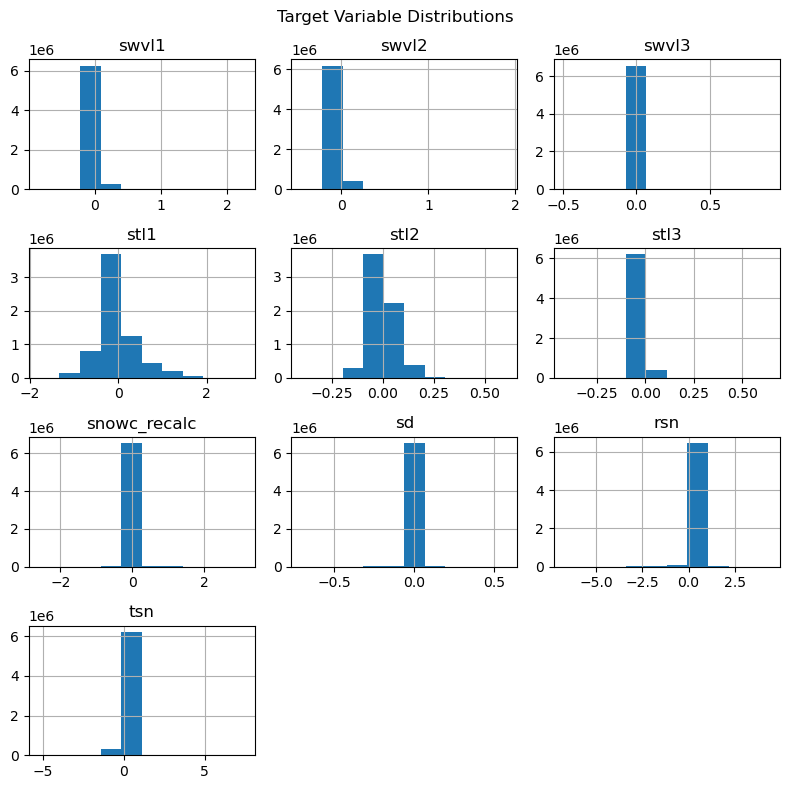

In [9]:
import pandas as pd

#mus = ds_example.y_prog_means.cpu().numpy()
std = ds_example.y_prog_stdevs.cpu().numpy()

ds_mean = ds_example.ds_ecland.data_1stdiff_means[ds_example.targ_index] / (std + 1e-8)
ds_std = ds_example.ds_ecland.data_1stdiff_stdevs[ds_example.targ_index] / (std + 1e-8)
#ds_mean = ds_example.ds_ecland.data_1stdiff_means[ds_example.targ_index] / (std - mus + 1e-5)
#ds_std = ds_example.ds_ecland.data_1stdiff_stdevs[ds_example.targ_index] / (std - mus + 1e-5)

#df = pd.DataFrame(yy.reshape(-1, len(ds_example.targ_lst)).cpu().numpy() / (ds_std), columns=ds_example.targ_lst)
df = pd.DataFrame(yy.reshape(-1, len(ds_example.targ_lst)).cpu().numpy(), columns=ds_example.targ_lst)
df.hist(figsize=(8,8),)
plt.suptitle("Target Variable Distributions")
plt.tight_layout()

del ds_example, xx, yy

In [10]:
#from pytorch_lightning.loggers import CSVLogger

data_module = NonLinRegDataModule()
dataset = EcDataset()
#csv_logger = CSVLogger('logs', name='testing')  # Change 'logs' to the directory where you want to save the logs

mus = dataset.y_prog_means.cpu().numpy()
std = dataset.y_prog_stdevs.cpu().numpy()

ds_mean = dataset.ds_ecland.data_1stdiff_means[dataset.targ_index] / (std + 1e-5)
ds_std = dataset.ds_ecland.data_1stdiff_stdevs[dataset.targ_index] / (std + 1e-5)
# ds_mean = dataset.ds_ecland.data_1stdiff_means[dataset.targ_index] / (std - mus + 1e-5)
# ds_std = dataset.ds_ecland.data_1stdiff_stdevs[dataset.targ_index] / (std - mus + 1e-5)

# train
input_clim_dim = dataset.x_static_scaled.shape[-1]
input_met_dim = len(dataset.dynamic_feat_lst)
input_state_dim = len(dataset.targ_lst)
output_dim = len(dataset.targ_lst)  # Number of output targets
hidden_dim = 172  # 128  # 86  # 172  # 128  # 172  # Number of hidden units
model_pyt = NonLinearRegression(
    input_clim_dim,
    input_met_dim,
    input_state_dim,
    hidden_dim,
    output_dim,
    mu_norm=ds_mean,
    std_norm=ds_std,
    dataset=dataset,
)

In [11]:
model_pyt

NonLinearRegression(
  (input_proj): Linear(in_features=40, out_features=172, bias=True)
  (skip): Linear(in_features=10, out_features=10, bias=True)
  (residual_blocks): ModuleList(
    (0-3): 4 x Sequential(
      (0): Linear(in_features=172, out_features=172, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): LayerNorm((172,), eps=1e-05, elementwise_affine=True)
    )
  )
  (output_proj): Linear(in_features=172, out_features=10, bias=True)
)

In [12]:
model_pyt.load_state_dict(torch.load("test_ecland_emu3.pyt").state_dict())
#torch.load("test_ecland_emu3.pyt").state_dict()

<All keys matched successfully>

In [13]:
# Load a previous trained model if applicable 
#model_pyt.load_state_dict(torch.load("logs/testing/version_12/checkpoints/epoch=45-step=6486.ckpt")["state_dict"])

In [14]:
from pytorch_lightning.loggers import CSVLogger
csv_logger = CSVLogger(save_dir='logs', name='testing')  # Change 'logs' to the directory where you want to save the logs

#torch.cuda.empty_cache()
torch.set_float32_matmul_precision("high")
# checkpoint_callback = ModelCheckpoint(monitor="val_step_loss", mode="min")
checkpoint_callback = ModelCheckpoint(monitor="val_loss", 
                                    dirpath=f"{csv_logger.log_dir}/checkpoints",  # Directory to save checkpoints
                                    filename='model-{epoch:02d}-{val_loss:.2f}',  # Checkpoint filename format
                                    save_top_k=1,  # Save only the best model
                                    mode='min',  # The lower the validation loss, the better
                                     )
# torch.set_float32_matmul_precision('medium')
trainer = pl.Trainer(
    callbacks=[checkpoint_callback],
    # precision='bf16-mixed',
    logger=csv_logger,
    max_epochs = 40  # 50,  # 40  # 100,  # 200,
)

trainer.fit(model_pyt, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params
-----------------------------------------------
0 | input_proj      | Linear     | 7.1 K 
1 | skip            | Linear     | 110   
2 | residual_blocks | ModuleList | 120 K 
3 | output_proj     | Linear     | 1.7 K 
-----------------------------------------------
129 K     Trainable params
0         Non-trainable params
129 K     Total params
0.517     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.


# Testing out the trained model

In [15]:
model_pyt.eval()
model_pyt.to(device)

# Open dataset for point validation
dataset = EcDataset(
        start_yr=2018,
        end_yr=2022,
        #path="/data/ecland_i6aj_o400_2010_2022_6h_euro.zarr",
        path="/hpcperm/daep/ecland_i6aj_2017_2022_6h_euro.zarr",
        roll_out=1,
        x_idxs = (5284, 5285)
    )

print(f"Prognostic targets = {dataset.targ_lst}")
print(f"Diagnostic targets = {dataset.targ_diag_lst}")

Prognostic targets = ['swvl1', 'swvl2', 'swvl3', 'stl1', 'stl2', 'stl3', 'snowc_recalc', 'sd', 'rsn', 'tsn']
Diagnostic targets = ['d2m', 't2m', 'skt']


In [16]:
# Load data and put it onto device
clim_norm, met_norm, state_norm, state_diag_norm = [out_tensor.to(device) for out_tensor in dataset.load_data()]

In [17]:
%%time
with torch.no_grad():
    # run model
    preds_norm = model_pyt.predict_step(clim_norm, met_norm, state_norm)
    
    # inverse "z" tranform targets and predictions
    preds = dataset.inv_transform(preds_norm, dataset.y_prog_means.to(dev), dataset.y_prog_stdevs.to(dev))
    preds = torch.clip(preds, 0, None)
    state = dataset.inv_transform(state_norm, dataset.y_prog_means.to(dev), dataset.y_prog_stdevs.to(dev))

CPU times: user 3.73 s, sys: 7.68 ms, total: 3.73 s
Wall time: 3.74 s


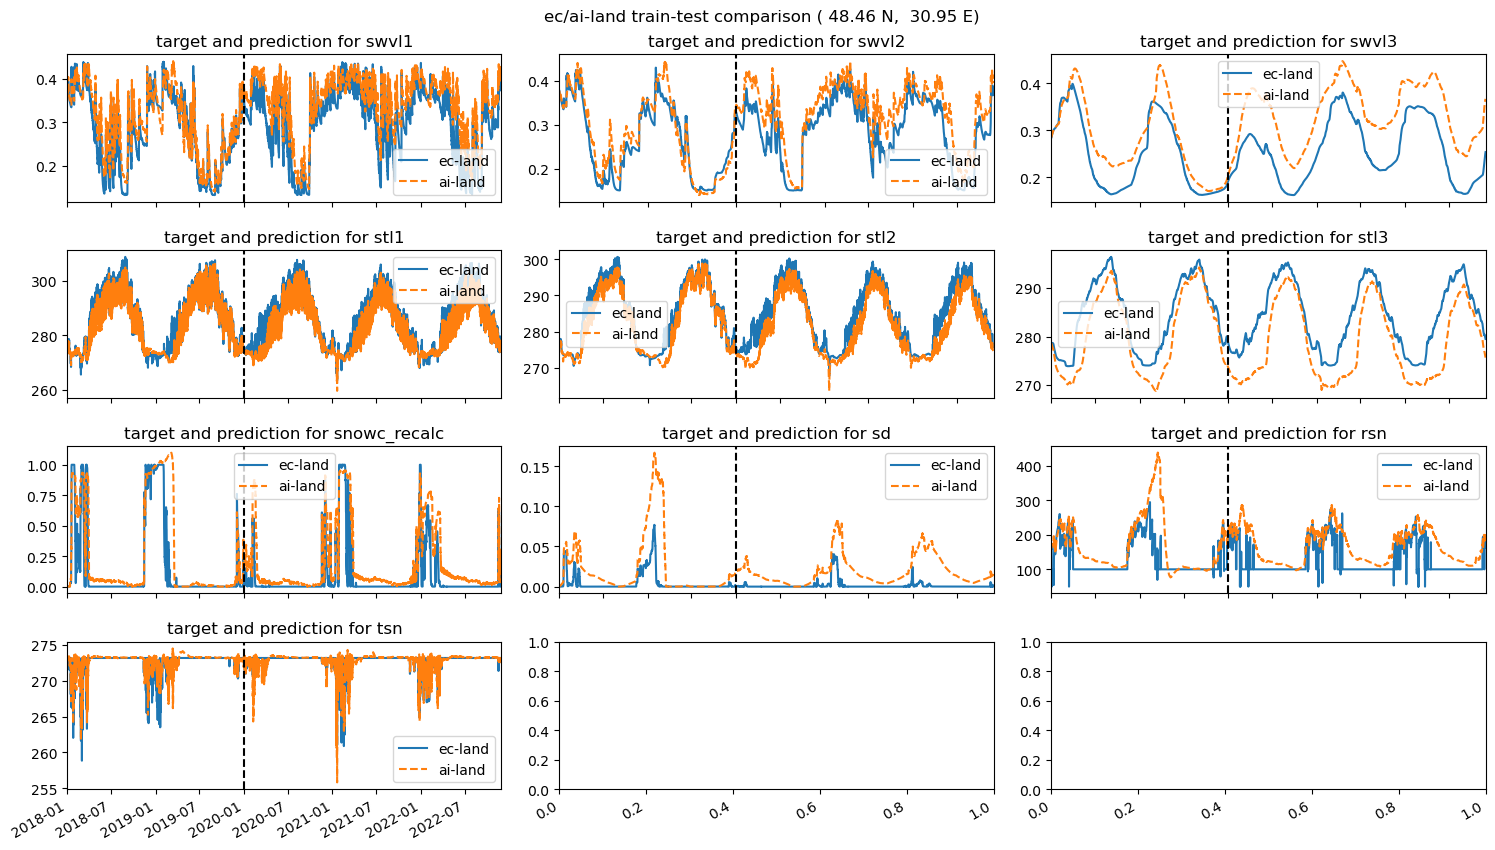

In [18]:
# Plot some timeseries validation for a specific gridcell
def plot_timeseries(times, targets, predictions, x_idx, state_idx, label, ax, val_start=2020):
    """Plots a time series for targets and predictions

    :param times: times on x-axis
    :param targets: ec-land model targets
    :param predictions: emulator predictions
    :param x_idx: spatial index to plot
    :param state_idx: state vector index to plot
    :param label: label for data variables
    :param ax: axes on which to plot the figure
    """
    ax.plot(times, targets[:, x_idx, state_idx].cpu().numpy(), label="ec-land")
    ax.plot(times, predictions[:, x_idx, state_idx].cpu().numpy(), '--', label="ai-land")
    ax.set_title(f"target and prediction for {label}")
    ax.set_xlim([times[0], times[-1]])
    t_idx = np.min(np.argwhere(pd.to_datetime(dataset.times).year == val_start))
    ax.axvline(times[t_idx], color="k", linestyle="--")
    ax.legend()

fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(15,10))

for i, var in enumerate(dataset.targ_lst):
    axes = ax.flatten()[i]
    plot_timeseries(dataset.times, state, preds, 0, i, var, axes)
    
#ax.flatten()[-2].remove()
#ax.flatten()[-1].remove()
fig.suptitle(f"ec/ai-land train-test comparison ({dataset.lats[0]: .2f} N, {dataset.lons[0]: .2f} E)")
fig.tight_layout()
fig.autofmt_xdate()

## Testing out model for an indepent years run over whole of Europe

We run the emulator forward 1 year and compare to the ec-land estimates over this time horizon

In [19]:
model_pyt.eval()
model_pyt.to(device)

# Open dataset for point validation
dataset = EcDataset(
        start_yr=2021,
        end_yr=2021,
        #path="/data/ecland_i6aj_o400_2010_2022_6h_euro.zarr",
        path="/hpcperm/daep/ecland_i6aj_2017_2022_6h_euro.zarr",
        roll_out=1,
    )

print(f"Prognostic targets = {dataset.targ_lst}")
print(f"Diagnostic targets = {dataset.targ_diag_lst}")

Prognostic targets = ['swvl1', 'swvl2', 'swvl3', 'stl1', 'stl2', 'stl3', 'snowc_recalc', 'sd', 'rsn', 'tsn']
Diagnostic targets = ['d2m', 't2m', 'skt']


In [20]:
# Load data and put it onto device
clim_norm, met_norm, state_norm, state_diag_norm = [out_tensor.to(device) for out_tensor in dataset.load_data()]

In [21]:
%%time
with torch.no_grad():
    # run model
    preds_norm = model_pyt.predict_step(clim_norm, met_norm, state_norm)
    
    # inverse "z" tranform targets and predictions
    preds = dataset.inv_transform(preds_norm, dataset.y_prog_means.to(dev), dataset.y_prog_stdevs.to(dev))
    preds = torch.clip(preds, 0, None)
    state = dataset.inv_transform(state_norm, dataset.y_prog_means.to(dev), dataset.y_prog_stdevs.to(dev))

CPU times: user 805 ms, sys: 814 µs, total: 806 ms
Wall time: 807 ms


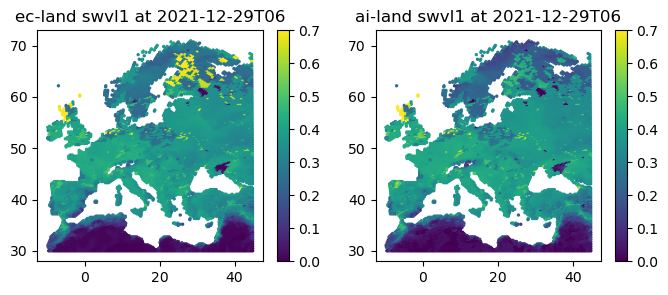

In [22]:
state_idx = 0
t_idx = -10

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))

c1 = ax[0].scatter(dataset.lons, dataset.lats, c=state[t_idx, :, state_idx].cpu().numpy(), vmin=0, vmax=0.7, s=2)
ax[0].set_title(f"ec-land {dataset.targ_lst[state_idx]} at {str(dataset.times[t_idx])[:13]}")
c2 = ax[1].scatter(dataset.lons, dataset.lats, c=preds[t_idx, :, state_idx].cpu().numpy(), vmin=0, vmax=0.7, s=2)
ax[1].set_title(f"ai-land {dataset.targ_lst[state_idx]} at {str(dataset.times[t_idx])[:13]}")
plt.colorbar(c1)
plt.colorbar(c2)

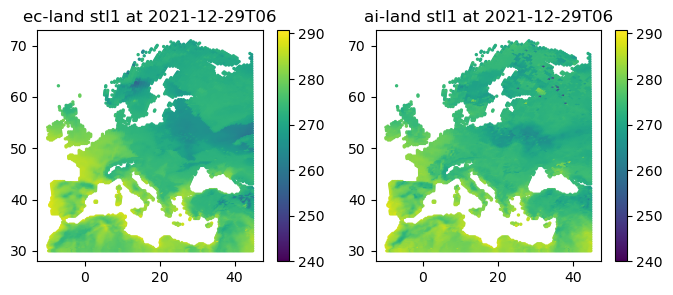

In [23]:
state_idx = 3
t_idx = -10

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))

c1 = ax[0].scatter(dataset.lons, dataset.lats, c=state[t_idx, :, state_idx].cpu().numpy(), vmin=240, vmax=290.7, s=2)
ax[0].set_title(f"ec-land {dataset.targ_lst[state_idx]} at {str(dataset.times[t_idx])[:13]}")
c2 = ax[1].scatter(dataset.lons, dataset.lats, c=preds[t_idx, :, state_idx].cpu().numpy(), vmin=240, vmax=290.7, s=2)
ax[1].set_title(f"ai-land {dataset.targ_lst[state_idx]} at {str(dataset.times[t_idx])[:13]}")
plt.colorbar(c1)
plt.colorbar(c2)

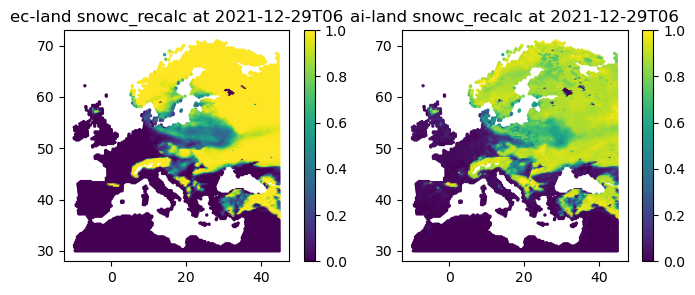

In [24]:
state_idx = 6
t_idx = -10

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))

c1 = ax[0].scatter(dataset.lons, dataset.lats, c=state[t_idx, :, state_idx].cpu().numpy(), vmin=0, vmax=1, s=2)
ax[0].set_title(f"ec-land {dataset.targ_lst[state_idx]} at {str(dataset.times[t_idx])[:13]}")
c2 = ax[1].scatter(dataset.lons, dataset.lats, c=preds[t_idx, :, state_idx].cpu().numpy(), vmin=0, vmax=1, s=2)
ax[1].set_title(f"ai-land {dataset.targ_lst[state_idx]} at {str(dataset.times[t_idx])[:13]}")
plt.colorbar(c1)
plt.colorbar(c2)

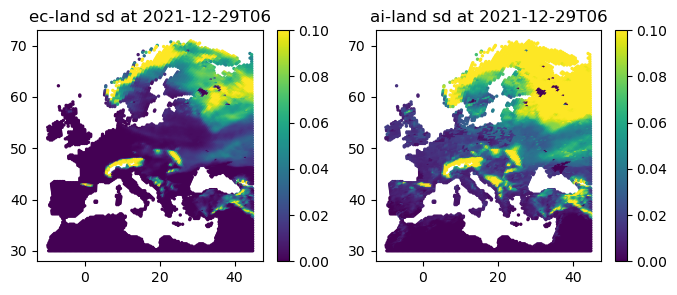

In [25]:
state_idx = 7
t_idx = -10

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))

c1 = ax[0].scatter(dataset.lons, dataset.lats, c=state[t_idx, :, state_idx].cpu().numpy(), vmin=0, vmax=0.1, s=2)
ax[0].set_title(f"ec-land {dataset.targ_lst[state_idx]} at {str(dataset.times[t_idx])[:13]}")
c2 = ax[1].scatter(dataset.lons, dataset.lats, c=preds[t_idx, :, state_idx].cpu().numpy(), vmin=0, vmax=0.1, s=2)
ax[1].set_title(f"ai-land {dataset.targ_lst[state_idx]} at {str(dataset.times[t_idx])[:13]}")
plt.colorbar(c1)
plt.colorbar(c2)

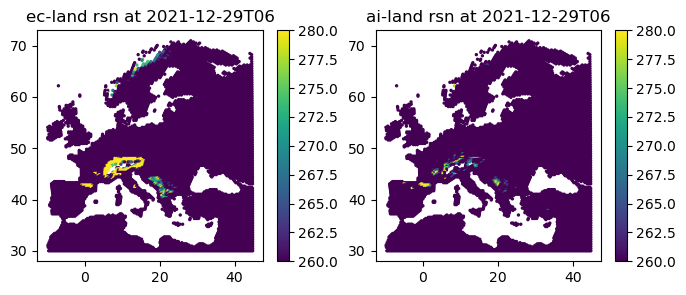

In [26]:
state_idx = 8
t_idx = -10

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))

c1 = ax[0].scatter(dataset.lons, dataset.lats, c=state[t_idx, :, state_idx].cpu().numpy(), vmin=260, vmax=280, s=2)
ax[0].set_title(f"ec-land {dataset.targ_lst[state_idx]} at {str(dataset.times[t_idx])[:13]}")
c2 = ax[1].scatter(dataset.lons, dataset.lats, c=preds[t_idx, :, state_idx].cpu().numpy(), vmin=260, vmax=280, s=2)
ax[1].set_title(f"ai-land {dataset.targ_lst[state_idx]} at {str(dataset.times[t_idx])[:13]}")
plt.colorbar(c1)
plt.colorbar(c2)

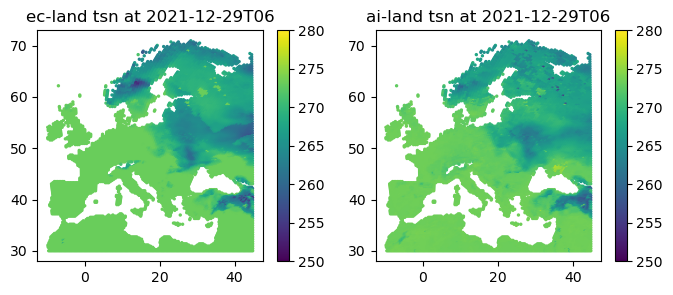

In [27]:
state_idx = 9
t_idx = -10

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))

c1 = ax[0].scatter(dataset.lons, dataset.lats, c=state[t_idx, :, state_idx].cpu().numpy(), vmin=250, vmax=280, s=2)
ax[0].set_title(f"ec-land {dataset.targ_lst[state_idx]} at {str(dataset.times[t_idx])[:13]}")
c2 = ax[1].scatter(dataset.lons, dataset.lats, c=preds[t_idx, :, state_idx].cpu().numpy(), vmin=250, vmax=280, s=2)
ax[1].set_title(f"ai-land {dataset.targ_lst[state_idx]} at {str(dataset.times[t_idx])[:13]}")
plt.colorbar(c1)
plt.colorbar(c2)

In [28]:
#torch.save(model_pyt, "test_ecland_emu2.pyt")

In [29]:
torch.save(model_pyt, "test_ecland_emu4.pyt")